# Apêndice A: Análise exploratória dos dados e criação das bases de dados do modelo ("Feature Engineering")

Neste apêndice será feita a análise será feita a limpeza dos dados origem, a análise exploratória dos dados e a seleção das variáveis que serão utilizadas para os modelos preditivos descida de gradiente (XGBoost eLightGBM) bem como no modelo de média móvel ARIMA.

In [2]:
import pandas as pd
import openpyxl
import numpy as np
import os
import glob2
import glob
import random
import sklearn
import ntpath
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from nltk.test.portuguese_en_fixt import setup_module
import nltk
from contextlib import nullcontext
import unicodedata
import plotly
import read_file_exec as rfe

O intuito desse anexo em Jupyter consiste em estudar os arquivos inputs e modelá-los para datasets a serem usados na aplicação de modelos matemáticos para predição de Vendas, para sugestão de estoque mínimo.

Arquivos input:

* Inventario.xlsx

| Coluna  |  Descrição | 
| ---------- | ---------:              |
| Descrição              |Descrição do produto |
| Código                 |Código de registro único de estoque |
| Estoque Atual          |Estoque atual |
| Estoque Reservado      |Estoque resevado de produto |
| Estoque Disponível     |Estoque Disponível do produto|
| Preço                  |Preço do produto baseado na última atualização |
| Categoria              |Categoria de família de produtos |
| Código Extra           |Códigos extras |
| Unidade                |Unidade do produto |
| Fornecedor Principal   |Fornecedor principal do produto |
| Código Ref.            |Código refência do Produto |
| Marca                  |Marca do Produto |
| Estoque Min.           |Estoque mínimo calculado do sistema |
| Estoque Max.           |Estoque máximo calculado do sistema |
| Abaixo Min.            |Abaixo do mínimo |
| Repor                  |Quantidade a ser reposta |
| Prêmio ?               |Se há alguma bonificação |
| Pontos Nec.            |Campo indefinido |
| Tributação             |Dados tributários |
| NCM                    |Código  |
| Kit / Combo            |Se é parte de kit ou combo |
| EAN / GTIN             |registro nacional do produto eletrônico (Código de barras) |
| Exportar para balança  |Campo indefinido |


----------------------------
* Transações_vendas.xlsx


| Coluna  |  Descrição | 
| ---------- | ----------:
|Ent                 |Campo indefinido          |
|Tipo                |Tipo de transação                 |
|Número              |número da transação                 |
|Data                |data da transação                 |
|Hora                |hora da transação                 |
|Cliente / Fornecedor|Cliente ou fornecedor                 |
|Itens               |Itens vendidos                 |
|Total Final         |Total das transação                 |
|Observações         |Observação da transação                 |
|Funcionário         |Funcionário responsável                 |
|Vendedor            |Vendedor                  |
|Subtotal            |Subtotal da transação                 |
|Desconto            |Desconto da transação                 |
|Outras Despesas     |Outras despesas                 |
|Frete               |Frete                 |
|Valor Pago          |Valor pago pelo cliente                 |
|Meio Pagto          |Meio de pagamento usado                 |
|Crédito Usado       |Crédito utilizado                 |
|Debitado            |Valor debitado                 |
|Troco               |Troco devolvido                 |
|Creditado           |Valor creditado                 |
|Documento           |Nota da transação                 |
|Chave Doc. Fiscal   | Chave do documento fiscal                |
-----------------------------------------------------

* Transações_por_produto.xlsx

| Coluna  |  Descrição | 
| ---------- | ---------: 
|NF                   |Nota fiscal |
|Ent                  |Campo indefinido |
|Tipo                 |Tipo de transação |
|Número               |Número da transação |
|Data                 |Data da transação |
|Hora                 |Hora da transação |
|Cliente / Fornecedor |Cliente ou Fornecedor |
|Produto              |Produto  |
|Quant.               |Transação em quantidades |
|Vl. Unitário         |Valor unitário |
|Sub-Total            |Sub total da transação |
|Desconto             |Desconto aplicado |
|Outras Despesas      |Outras despesas |
|Total                |Total da transação |
|Funcionário          |Funcionário responsável |
|Valor Comissão       |Valor da comissão |
|Comissão %           |Porcentagem da comissão |
|Calc.Comissão        |Cálculo da comissão |

In [3]:
#Função para listar campos nulos de um dataframe e remover as colunas puramente nulas


def list_columns_and_remove_nullcontext(df):
    null_columns= []
    for column in df.columns:
        if df[column].isnull().all():
            null_columns = null_columns + [column]
    print(null_columns)
    df.drop(null_columns, axis=1, inplace=True)

In [4]:

def normalize_string(string):
        return ''.join(char for char in unicodedata.normalize('NFD', string) if unicodedata.category(char) != 'Mn')
    
def lower_string(string):
        return string.lower()

In [5]:
## Função para achar inconsistências em um dataframe
nat_as_integer = np.datetime64('NaT').view('i8')

def isnat(your_datetime):
    dtype_string = str(your_datetime.dtype)
    if 'datetime64[ns]' in dtype_string or 'timestamp64' in dtype_string:
        return your_datetime.view('i8') == nat_as_integer
    return False  # it can't be a NaT if it's not a dateime

In [6]:
def prepare_columns(df):   
    df.columns = [label.replace(' ', '_') for label in df.columns]
    df.columns = [label.replace('/', '_') for label in df.columns]
    df.columns = [label.replace('-', '_') for label in df.columns]
    df.columns = [label.replace('(', '_') for label in df.columns]
    df.columns = [label.replace(')', '_') for label in df.columns]
    df.columns = [label.replace('.', '_') for label in df.columns]
    df.columns = [label.replace(',', '_') for label in df.columns]
    df.columns = [label.replace(';', '_') for label in df.columns]
    df.columns = [label.replace(':', '_') for label in df.columns]
    df.columns = [label.replace('?', '_') for label in df.columns]
    df.columns = [label.replace('!', '_') for label in df.columns]
    df.columns = [label.replace('#', '_') for label in df.columns]
    df.columns = [label.replace('$', '_') for label in df.columns]
    df.columns = [label.replace('%', '_') for label in df.columns]
    df.columns = [label.replace('^', '_') for label in df.columns]
    df.columns = [label.replace('&', '_') for label in df.columns]
    df.columns = [label.replace('*', '_') for label in df.columns]
    df.columns = [label.replace('(', '_') for label in df.columns]
    df.columns = [label.replace(')', '_') for label in df.columns]
    df.columns = [label.replace('+', '_') for label in df.columns]
    df.columns = [label.replace('=', '_') for label in df.columns]
    df.columns = [label.lower() for label in df.columns]
    df.columns = [normalize_string(label) for label in df.columns]
    df.columns = [label.replace('á', 'a') for label in df.columns]
    df.columns = [label.replace('é', 'e') for label in df.columns]
    df.columns = [label.replace('í', 'i') for label in df.columns]
    df.columns = [label.replace('ó', 'o') for label in df.columns]
    df.columns = [label.replace('ú', 'u') for label in df.columns]
    df.columns = [label.replace('ç', 'c') for label in df.columns]
    df.columns = [label.replace('ã', 'a') for label in df.columns]
    df.columns = [label.replace('õ', 'o') for label in df.columns]
    df.columns = [label.replace('â', 'a') for label in df.columns]
    df.columns = [label.replace('ê', 'e') for label in df.columns]
    df.columns = [label.replace('ô', 'o') for label in df.columns]
    df.columns = [label.replace('ì', 'i') for label in df.columns]
    df.columns = [label.replace('ù', 'u') for label in df.columns]
    df.columns = [label.replace('à', 'a') for label in df.columns]
    df.columns = [label.replace('è', 'e') for label in df.columns]
    df.columns = [label.replace('ì', 'i') for label in df.columns]
    df.columns = [label.replace('ò', 'o') for label in df.columns]
    df.columns = [label.replace('ù', 'u') for label in df.columns]

#### Criação dos dataframes do modelo

In [7]:
dataframe_inventario = rfe.read_file('Files/Inventario.xlsx').get_df() # Cria dataframe de inventário ## Normaliza os nomes das colunas
prepare_columns(dataframe_inventario) # Normaliza os nomes das colunas
dataframe_transacoes_produto = rfe.read_file('Files/Transações_por_produto.xlsx').get_df() #.prepare_columns() # Cria dataframe de transações por produto ## Normaliza os nomes das colunas
prepare_columns(dataframe_transacoes_produto) # Normaliza os nomes das colunas
dataframe_transacoes_vendas = rfe.read_file('Files/Transações_vendas.xlsx').get_df()#.prepare_columns() # Cria dataframe de transações por venda ## Normaliza os nomes das colunas
prepare_columns(dataframe_transacoes_vendas) # Normaliza os nomes das colunas
dataframe_ipca = rfe.read_file('Files/ipca_modelo.xlsx').get_df()#.prepare_columns() # Cria dataframe de transações por venda ## Normaliza os nomes das colunas
prepare_columns(dataframe_ipca) # Normaliza os nomes das colunas
dataframe_deprec = rfe.read_file('Files/NCM.xlsx').get_df()#.prepare_columns() # Cria dataframe de transações por venda ## Normaliza os nomes das colunas
prepare_columns(dataframe_deprec) # Normaliza os nomes das colunas

In [8]:
dataframe_deprec.head(20)

,categoria,ncm,taxa_depreciacao
0,armarinho,8452,10
1,artesanato,6303,20
2,aviamento,8452,10
3,decoracao,6303,20
4,enxoval,6303,20
5,la,6303,20
6,mdf,4415,20
7,outros,*,20
8,papelaria,3926,0
9,roupas,6303,20


In [9]:
dataframe_deprec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   categoria         13 non-null     object
 1   ncm               13 non-null     object
 2   taxa_depreciacao  13 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 440.0+ bytes


In [10]:
dataframe_ipca.head(20)

,mes,indice
0,2020-03-01,5348.49
1,2020-04-01,5331.91
2,2020-05-01,5311.65
3,2020-06-01,5325.46
4,2020-07-01,5344.63
5,2020-08-01,5357.46
6,2020-09-01,5391.75
7,2020-10-01,5438.12
8,2020-11-01,5486.52
9,2020-12-01,5560.59


In [11]:
dataframe_ipca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   mes     29 non-null     datetime64[ns]
 1   indice  29 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 592.0 bytes


In [12]:
dataframe_inventario.head()



,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,codigo_extra,unidade,fornecedor_principal,...,comissao,localizacao,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca
0,APLIQUE - APM4 -053 NOIVOS,7100692,9.0,0.0,9.0,2.5,PAPELARIA,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,7.893798e+12,Não
1,BARROCO MULT 200G -9384 GREENNERY,099810,0.0,0.0,0.0,22.8,Linha,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,7.891114e+12,Não
2,ABAJUR MARINHEIRO,124205,1.0,0.0,1.0,38.0,MDF,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
4,ABRIDOR DE CASA G,7101086,2.0,0.0,2.0,5.0,ARMARINHO,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não


In [13]:
dataframe_inventario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261 entries, 0 to 5260
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   descricao              5261 non-null   object        
 1   codigo                 5247 non-null   object        
 2   estoque_atual          5247 non-null   float64       
 3   estoque_reservado      5245 non-null   float64       
 4   estoque_disponivel     5244 non-null   float64       
 5   preco                  5247 non-null   float64       
 6   categoria              5234 non-null   object        
 7   codigo_extra           0 non-null      float64       
 8   unidade                557 non-null    object        
 9   fornecedor_principal   2 non-null      object        
 10  codigo_ref_            0 non-null      float64       
 11  marca                  3921 non-null   object        
 12  estoque_min_           5247 non-null   float64       
 13  est

In [14]:
dataframe_transacoes_produto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47175 entries, 0 to 47174
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   nf                    0 non-null      float64       
 1   ent                   0 non-null      float64       
 2   tipo                  37170 non-null  object        
 3   numero                37170 non-null  float64       
 4   data                  37170 non-null  datetime64[ns]
 5   hora                  37170 non-null  datetime64[ns]
 6   cliente___fornecedor  2 non-null      object        
 7   produto               47175 non-null  object        
 8   quant_                47175 non-null  float64       
 9   vl__unitario          47175 non-null  float64       
 10  sub_total             47175 non-null  float64       
 11  desconto              47175 non-null  float64       
 12  outras_despesas       47175 non-null  int64         
 13  total           

In [15]:
dataframe_transacoes_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37170 entries, 0 to 37169
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ent                   0 non-null      float64       
 1   tipo                  37170 non-null  object        
 2   numero                37170 non-null  int64         
 3   data                  37170 non-null  datetime64[ns]
 4   hora                  37170 non-null  datetime64[ns]
 5   cliente___fornecedor  3 non-null      object        
 6   itens                 37170 non-null  object        
 7   total_final           37170 non-null  float64       
 8   observacoes           32 non-null     object        
 9   funcionario           37033 non-null  object        
 10  vendedor              9479 non-null   object        
 11  subtotal              9888 non-null   object        
 12  desconto              37170 non-null  float64       
 13  outras_despesas 

#### Checando o dataframe de transação

In [16]:
dataframe_transacoes_produto.head(15)

,nf,ent,tipo,numero,data,hora,cliente___fornecedor,produto,quant_,vl__unitario,sub_total,desconto,outras_despesas,total,funcionario,valor_comissao,comissao__,calc_comissao
0,NaN,NaN,Venda,38253.0,2022-07-30 11:45:35.193,2022-07-30 11:45:35.193,NaN,TECIDO TRICOLINE DIVERSOS,-0.25,27.90,6.97,0.00,0,6.97,Administrador,0,0,Sob.Total
1,NaN,NaN,Venda,38252.0,2022-07-30 09:45:20.596,2022-07-30 09:45:20.596,NaN,FITA CETIM PROGRESSO 0 -209 VERMELHO,-100.00,0.35,35.00,7.00,0,28.00,Administrador,0,0,Sob.Total
2,NaN,NaN,Venda,38251.0,2022-07-30 09:36:37.140,2022-07-30 09:36:37.140,NaN,"FITA MÉTRICA NYBC 1,5m",-1.00,5.80,5.80,0.00,0,5.80,Administrador,0,0,Sob.Total
3,NaN,NaN,NaN,NaN,NaT,NaT,NaN,COSTURA DRIMA - Branca,-1.00,3.00,3.00,0.00,0,3.00,Administrador,0,0,Sob.Total
4,NaN,NaN,NaN,NaN,NaT,NaT,NaN,COSTURA DRIMA - 5605,-1.00,3.00,3.00,0.00,0,3.00,Administrador,0,0,Sob.Total
5,NaN,NaN,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,MINIATURA LASER CADEIRA,-2.00,4.80,9.60,0.00,0,9.60,Administrador,0,0,Sob.Total
6,NaN,NaN,NaN,NaN,NaT,NaT,NaN,COLA TEK BOND 2 20G,-1.00,16.80,16.80,0.00,0,16.80,Administrador,0,0,Sob.Total
7,NaN,NaN,Venda,38247.0,2022-07-29 16:37:15.597,2022-07-29 16:37:15.597,NaN,AGULHA COSTURA -Darning MILWARD 5,-3.00,1.00,3.00,0.00,0,3.00,Administrador,0,0,Sob.Total
8,NaN,NaN,NaN,NaN,NaT,NaT,NaN,AGULHA COSTURA -Darning MILWARD 3,-2.00,1.00,2.00,0.00,0,2.00,Administrador,0,0,Sob.Total
9,NaN,NaN,NaN,NaN,NaT,NaT,NaN,AGULHA COSTURA -Darning N 1,-2.00,1.25,2.50,0.00,0,2.50,Administrador,0,0,Sob.Total


Como podemos ver, neste caso tivemos o arquivo agrupado no excel. O mesmo agrupamento não foi mantido na leitura, assim sendo necessário além da remoção de colunas nulas, uma função em que replique o último valor por cada tranação para que complete os dados que competem à mesma transação.

#### Checando o dataframe de inventário

In [17]:
dataframe_inventario.head()

,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,codigo_extra,unidade,fornecedor_principal,...,comissao,localizacao,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca
0,APLIQUE - APM4 -053 NOIVOS,7100692,9.0,0.0,9.0,2.5,PAPELARIA,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,7.893798e+12,Não
1,BARROCO MULT 200G -9384 GREENNERY,099810,0.0,0.0,0.0,22.8,Linha,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,7.891114e+12,Não
2,ABAJUR MARINHEIRO,124205,1.0,0.0,1.0,38.0,MDF,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
4,ABRIDOR DE CASA G,7101086,2.0,0.0,2.0,5.0,ARMARINHO,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não


Para os arquivos de inventário, é possível remover colunas puramente nulas, pois também, como no dataframe anterior, não agregarão ao modelo.

#### Limpeza e adequação dos dados: 


### Dataframe de Transações por produto

Neste caso, é interessante o uso do método de beforefill do pandas par que o registro posterior receba o valor do anterior, assim ajustando os agrupamentos do arquivo xlsx.

In [18]:
dataframe_transacoes_produto['tipo'] = dataframe_transacoes_produto['tipo'].fillna(method='bfill')
dataframe_transacoes_produto['numero'] = dataframe_transacoes_produto['numero'].fillna(method='bfill')
dataframe_transacoes_produto['data'] = dataframe_transacoes_produto['data'].fillna(method='bfill')
dataframe_transacoes_produto['hora'] = dataframe_transacoes_produto['hora'].fillna(method='bfill')

In [19]:
dataframe_transacoes_produto_tratado = dataframe_transacoes_produto
dataframe_transacoes_produto_tratado.head()

,nf,ent,tipo,numero,data,hora,cliente___fornecedor,produto,quant_,vl__unitario,sub_total,desconto,outras_despesas,total,funcionario,valor_comissao,comissao__,calc_comissao
0,NaN,NaN,Venda,38253.0,2022-07-30 11:45:35.193,2022-07-30 11:45:35.193,NaN,TECIDO TRICOLINE DIVERSOS,-0.25,27.90,6.97,0.0,0,6.97,Administrador,0,0,Sob.Total
1,NaN,NaN,Venda,38252.0,2022-07-30 09:45:20.596,2022-07-30 09:45:20.596,NaN,FITA CETIM PROGRESSO 0 -209 VERMELHO,-100.00,0.35,35.00,7.0,0,28.00,Administrador,0,0,Sob.Total
2,NaN,NaN,Venda,38251.0,2022-07-30 09:36:37.140,2022-07-30 09:36:37.140,NaN,"FITA MÉTRICA NYBC 1,5m",-1.00,5.80,5.80,0.0,0,5.80,Administrador,0,0,Sob.Total
3,NaN,NaN,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,COSTURA DRIMA - Branca,-1.00,3.00,3.00,0.0,0,3.00,Administrador,0,0,Sob.Total
4,NaN,NaN,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,COSTURA DRIMA - 5605,-1.00,3.00,3.00,0.0,0,3.00,Administrador,0,0,Sob.Total


Neste passo para uma boa análise exploratória dos dados, é interessante remover colunas desinteressantes para o modelo. A função criada no início do modelo pode ser usada para a remoção de campos nulos de cada dataframe.

In [20]:
list_columns_and_remove_nullcontext(dataframe_transacoes_produto_tratado)
dataframe_transacoes_produto_tratado.head()


['nf', 'ent']


,tipo,numero,data,hora,cliente___fornecedor,produto,quant_,vl__unitario,sub_total,desconto,outras_despesas,total,funcionario,valor_comissao,comissao__,calc_comissao
0,Venda,38253.0,2022-07-30 11:45:35.193,2022-07-30 11:45:35.193,NaN,TECIDO TRICOLINE DIVERSOS,-0.25,27.90,6.97,0.0,0,6.97,Administrador,0,0,Sob.Total
1,Venda,38252.0,2022-07-30 09:45:20.596,2022-07-30 09:45:20.596,NaN,FITA CETIM PROGRESSO 0 -209 VERMELHO,-100.00,0.35,35.00,7.0,0,28.00,Administrador,0,0,Sob.Total
2,Venda,38251.0,2022-07-30 09:36:37.140,2022-07-30 09:36:37.140,NaN,"FITA MÉTRICA NYBC 1,5m",-1.00,5.80,5.80,0.0,0,5.80,Administrador,0,0,Sob.Total
3,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,COSTURA DRIMA - Branca,-1.00,3.00,3.00,0.0,0,3.00,Administrador,0,0,Sob.Total
4,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,COSTURA DRIMA - 5605,-1.00,3.00,3.00,0.0,0,3.00,Administrador,0,0,Sob.Total


In [21]:
dataframe_transacoes_produto_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47175 entries, 0 to 47174
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tipo                  47175 non-null  object        
 1   numero                47175 non-null  float64       
 2   data                  47175 non-null  datetime64[ns]
 3   hora                  47175 non-null  datetime64[ns]
 4   cliente___fornecedor  2 non-null      object        
 5   produto               47175 non-null  object        
 6   quant_                47175 non-null  float64       
 7   vl__unitario          47175 non-null  float64       
 8   sub_total             47175 non-null  float64       
 9   desconto              47175 non-null  float64       
 10  outras_despesas       47175 non-null  int64         
 11  total                 47175 non-null  float64       
 12  funcionario           46952 non-null  object        
 13  valor_comissao  

In [22]:

dataframe_transacoes_produto_tratado.isnull().sum()


tipo                        0
numero                      0
data                        0
hora                        0
cliente___fornecedor    47173
produto                     0
quant_                      0
vl__unitario                0
sub_total                   0
desconto                    0
outras_despesas             0
total                       0
funcionario               223
valor_comissao              0
comissao__                  0
calc_comissao           27285
dtype: int64

In [23]:
dataframe_transacoes_produto_tratado.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
numero,47175.0,20458.603922,10843.825850,1.00,11753.5,21035.0,29809.000,38253.0
quant_,47175.0,2.250551,125.751798,-10092.06,-1.0,-1.0,0.000,11988.0
vl__unitario,47175.0,6.850450,17.851295,0.00,0.0,2.5,9.375,1174.0
sub_total,47175.0,5.838035,14.485489,0.00,0.0,0.0,6.000,700.0
desconto,47175.0,0.159503,1.440226,0.00,0.0,0.0,0.000,98.0
outras_despesas,47175.0,0.000000,0.000000,0.00,0.0,0.0,0.000,0.0
total,47175.0,5.678532,13.948205,0.00,0.0,0.0,6.000,700.0
valor_comissao,47175.0,0.000000,0.000000,0.00,0.0,0.0,0.000,0.0
comissao__,47175.0,0.000000,0.000000,0.00,0.0,0.0,0.000,0.0


Como há vários valores nules no campo de clientes/fornecedores, além de metade das transações de cáculo de comissão serem nulas, removeremos os dados destes campos citados mais os dados de funcionário, pois não agregarão ao modelo.

In [24]:
dataframe_transacoes_produto_tratado = dataframe_transacoes_produto_tratado.drop(columns=['cliente___fornecedor','funcionario','calc_comissao','valor_comissao','comissao__'])
dataframe_transacoes_produto_tratado.head()

,tipo,numero,data,hora,produto,quant_,vl__unitario,sub_total,desconto,outras_despesas,total
0,Venda,38253.0,2022-07-30 11:45:35.193,2022-07-30 11:45:35.193,TECIDO TRICOLINE DIVERSOS,-0.25,27.90,6.97,0.0,0,6.97
1,Venda,38252.0,2022-07-30 09:45:20.596,2022-07-30 09:45:20.596,FITA CETIM PROGRESSO 0 -209 VERMELHO,-100.00,0.35,35.00,7.0,0,28.00
2,Venda,38251.0,2022-07-30 09:36:37.140,2022-07-30 09:36:37.140,"FITA MÉTRICA NYBC 1,5m",-1.00,5.80,5.80,0.0,0,5.80
3,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,COSTURA DRIMA - Branca,-1.00,3.00,3.00,0.0,0,3.00
4,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,COSTURA DRIMA - 5605,-1.00,3.00,3.00,0.0,0,3.00


Contabilizando valores nulos em cada coluna do dataframe de transações por produto:


### Dataframe de Inventário

O mesmo tratamento de remoção de colunas puramente nulas será feito para o dataframe de inventário.

In [25]:
dataframe_inventario_tratado = dataframe_inventario
list_columns_and_remove_nullcontext(dataframe_inventario_tratado)
dataframe_inventario_tratado.head()

['codigo_extra', 'codigo_ref_', 'pontos_nec_', 'tributacao', 'ncm', 'cest', 'peso_liq_', 'peso_bruto', 'comissao', 'localizacao']


,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,unidade,fornecedor_principal,marca,...,alterado_em,alterado_por,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca
0,APLIQUE - APM4 -053 NOIVOS,7100692,9.0,0.0,9.0,2.5,PAPELARIA,NaN,NaN,LITOARTE,...,2021-04-13 15:15:27.708,admin,NAO,NaT,NaT,NaN,Ativo,Não,7.893798e+12,Não
1,BARROCO MULT 200G -9384 GREENNERY,099810,0.0,0.0,0.0,22.8,Linha,NaN,NaN,Círculo,...,2022-05-07 07:56:56.014,admin,NAO,NaT,NaT,NaN,Ativo,Não,7.891114e+12,Não
2,ABAJUR MARINHEIRO,124205,1.0,0.0,1.0,38.0,MDF,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,NaN,NaN,NaN,NaN,...,2022-02-08 09:41:08.406,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
4,ABRIDOR DE CASA G,7101086,2.0,0.0,2.0,5.0,ARMARINHO,NaN,NaN,NaN,...,2021-10-11 09:35:33.641,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não


In [26]:
dataframe_inventario_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261 entries, 0 to 5260
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   descricao              5261 non-null   object        
 1   codigo                 5247 non-null   object        
 2   estoque_atual          5247 non-null   float64       
 3   estoque_reservado      5245 non-null   float64       
 4   estoque_disponivel     5244 non-null   float64       
 5   preco                  5247 non-null   float64       
 6   categoria              5234 non-null   object        
 7   unidade                557 non-null    object        
 8   fornecedor_principal   2 non-null      object        
 9   marca                  3921 non-null   object        
 10  estoque_min_           5247 non-null   float64       
 11  estoque_max_           5247 non-null   float64       
 12  abaixo_min_            5247 non-null   object        
 13  rep

In [27]:
dataframe_inventario_tratado.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
estoque_atual,5247.0,1.745982e+01,1.462484e+02,-28.00,1.000000e+00,4.000000e+00,9.000000e+00,5.443000e+03
estoque_reservado,5245.0,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
estoque_disponivel,5244.0,1.746981e+01,1.462896e+02,-28.00,1.000000e+00,4.000000e+00,9.000000e+00,5.443000e+03
preco,5247.0,1.515103e+01,3.116881e+01,0.06,3.500000e+00,6.800000e+00,1.980000e+01,7.500000e+02
estoque_min_,5247.0,1.905851e-03,1.380526e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01
estoque_max_,5247.0,7.623404e-03,5.522102e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+01
repor,1.0,3.850000e+01,NaN,38.50,3.850000e+01,3.850000e+01,3.850000e+01,3.850000e+01
preco_promocional,2.0,1.600000e+01,0.000000e+00,16.00,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01
ean___gtin,3630.0,7.840955e+12,2.283233e+12,3410394.00,7.891020e+12,7.891114e+12,7.893798e+12,6.789939e+13


In [28]:
dataframe_inventario_tratado[dataframe_inventario_tratado['categoria'].isnull()]

,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,unidade,fornecedor_principal,marca,...,alterado_em,alterado_por,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,NaN,NaN,NaN,NaN,...,2022-02-08 09:41:08.406,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
7,PROMOÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
9,PROMOÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
11,PROMOÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
13,PROMOÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
403,ARGOLA CHAVEIRO SEM CORRENTE,8099803,-14.0,0.0,-14.0,0.3,NaN,NaN,NaN,NaN,...,2022-05-11 12:16:01.547,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
868,BOLSA CROCHÊ ALÇA BARROCO TARTARUGA,8099950,0.0,0.0,0.0,130.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
869,BOLSA CROCHÊ FIO DE MALHA P,8099950,1.0,0.0,1.0,60.0,NaN,NaN,NaN,NaN,...,2022-07-29 11:34:28.238,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
894,DE ALGODÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
975,LA SEDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN


Neste caso temos alguns registros com código vazio. Estes serão desconsiderados do modelo. Repetiremos a análise de registros com categoria nula após a remoção dos citados para um enriquecimento destes casos já que são poucos.

In [29]:
dataframe_inventario_tratado = dataframe_inventario[dataframe_inventario['codigo'].notnull()]

In [30]:
dataframe_inventario_tratado[dataframe_inventario_tratado['codigo'].isnull()]

,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,unidade,fornecedor_principal,marca,...,alterado_em,alterado_por,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca


In [31]:
dataframe_inventario_tratado[dataframe_inventario_tratado['categoria'].isnull()]

,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,unidade,fornecedor_principal,marca,...,alterado_em,alterado_por,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,NaN,NaN,NaN,NaN,...,2022-02-08 09:41:08.406,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
403,ARGOLA CHAVEIRO SEM CORRENTE,8099803,-14.0,0.0,-14.0,0.3,NaN,NaN,NaN,NaN,...,2022-05-11 12:16:01.547,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
868,BOLSA CROCHÊ ALÇA BARROCO TARTARUGA,8099950,0.0,0.0,0.0,130.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
869,BOLSA CROCHÊ FIO DE MALHA P,8099950,1.0,0.0,1.0,60.0,NaN,NaN,NaN,NaN,...,2022-07-29 11:34:28.238,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
1455,CX PORTA BARALHO,8099862,0.0,0.0,0.0,5.5,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
1493,DEDEIRA DE BORRACHA,8099737,9.0,0.0,9.0,2.0,NaN,UNDD,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3087,MDF VASO GRANDE,8099768,0.0,0.0,0.0,27.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3628,MOSQUETÃO CIRCULO PRATA,8099940,36.0,0.0,36.0,3.5,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,7.891113e+12,Não
3977,PASSA ELÁSTICO PINÇA,8099654,6.0,0.0,6.0,2.9,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
4061,PLACA MDF DECORADA BEBE URSA,8099512,0.0,0.0,0.0,55.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não


Tendo apenas 13 casos, é possível atribuir manualmente um valor de categoria como outros para os casos em que o código não foi informado, não sendo algo que enviesará o modelo, pois como visto, temos cerca de 5400 registros. Estes registros comporão não só inventário, mas serão fonte de cruzamento como uma dimensão que enriquecerá as transações com suas famílias de produtos (categoria).

In [32]:
dataframe_inventario_tratado['categoria'] = dataframe_inventario_tratado['categoria'].fillna('Outros')
dataframe_inventario_tratado['estoque_disponivel'] = dataframe_inventario_tratado['estoque_disponivel'].fillna(0)

dataframe_inventario_tratado.head()


c:\users\otavi\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,unidade,fornecedor_principal,marca,...,alterado_em,alterado_por,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca
0,APLIQUE - APM4 -053 NOIVOS,7100692,9.0,0.0,9.0,2.5,PAPELARIA,NaN,NaN,LITOARTE,...,2021-04-13 15:15:27.708,admin,NAO,NaT,NaT,NaN,Ativo,Não,7.893798e+12,Não
1,BARROCO MULT 200G -9384 GREENNERY,099810,0.0,0.0,0.0,22.8,Linha,NaN,NaN,Círculo,...,2022-05-07 07:56:56.014,admin,NAO,NaT,NaT,NaN,Ativo,Não,7.891114e+12,Não
2,ABAJUR MARINHEIRO,124205,1.0,0.0,1.0,38.0,MDF,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,Outros,NaN,NaN,NaN,...,2022-02-08 09:41:08.406,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
4,ABRIDOR DE CASA G,7101086,2.0,0.0,2.0,5.0,ARMARINHO,NaN,NaN,NaN,...,2021-10-11 09:35:33.641,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não


In [33]:
dataframe_inventario_tratado.isnull().sum()

descricao                   0
codigo                      0
estoque_atual               0
estoque_reservado           2
estoque_disponivel          0
preco                       0
categoria                   0
unidade                  4690
fornecedor_principal     5245
marca                    1326
estoque_min_                0
estoque_max_                0
abaixo_min_                 0
repor                    5246
premio__                    0
incluido_em                 0
alterado_em              1157
alterado_por             1157
promocao                    0
data_inicial             5245
data_final               5245
preco_promocional        5245
status                      0
kit___combo                 0
ean___gtin               1617
exportar_para_balanca       0
dtype: int64

In [34]:
dataframe_inventario_tratado['categoria'].value_counts()

Linha         1639
ARMARINHO     1197
PAPELARIA     1123
LÃ             482
MDF            415
ENXOVAL        192
ARTESANATO     123
TECIDO          27
aviamento       23
Outros          13
LA              10
SERVIÇOS         1
Decoração        1
Roupas           1
Name: categoria, dtype: int64

In [35]:
dataframe_inventario_tratado['categoria'] = dataframe_inventario_tratado['categoria'].apply(lambda x: normalize_string(x)).apply(lambda x: lower_string(x))
dataframe_inventario_tratado['categoria'].value_counts()

c:\users\otavi\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


linha         1639
armarinho     1197
papelaria     1123
la             492
mdf            415
enxoval        192
artesanato     123
tecido          27
aviamento       23
outros          13
servicos         1
decoracao        1
roupas           1
Name: categoria, dtype: int64

Com os campos agora normalizados pelas funções presentes no na classe read_file normalize_string e lower_string, podemos tratar os dados de inventário para melhor contabilizá-los. Como o intuito desta parte é a melhoria e padronização dos dados, exploraremos os dados assim que tivermos um bom padrão para iniciar as análises.
O padrão deve seguir maneiras em que o dado há redução de ruídos de operação dos códigos de checagem para cruzamento dos dados com os dados de transação.


### Análises exploratórias dos dados

Iniciaremos a análise exploratória a partir dos dados de estoque trazendo alguns agrupamentos de dados que nos guiarão na análise.

<Figure size 640x480 with 0 Axes>

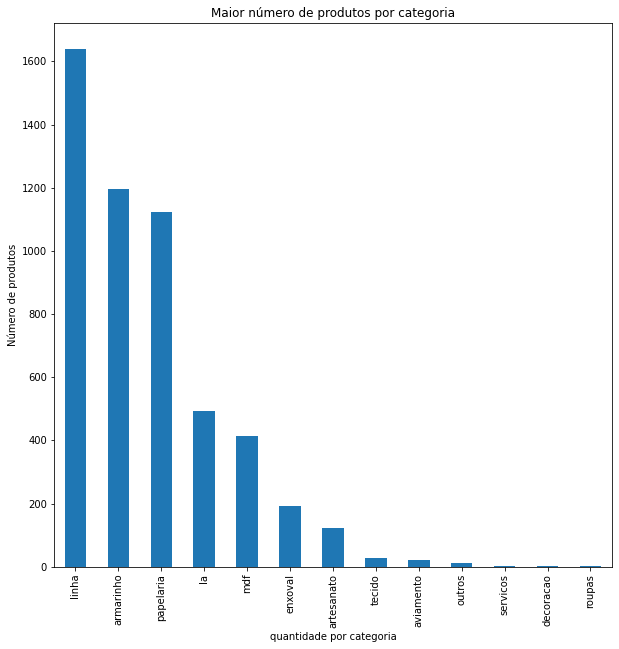

In [36]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)


plot_rank_categoria = dataframe_inventario_tratado['categoria'].value_counts().plot(kind='bar', title='Maior número de produtos por categoria',figsize=(10,10))
plot_rank_categoria.set_xlabel('quantidade por categoria')
plot_rank_categoria.set_ylabel('Número de produtos')
plt.show()


____________________________
| Categoria  |  Quantidade de produtos de registrados |
| ---------- | ---------:              |
|linha       |  1639                   |  
|armarinho   |  1197                   |  
|papelaria   |  1123                   |  
|la          |   492                   |  
|mdf         |   415                   |  
|enxoval     |   192                   |  
|artesanato  |   123                   |  
|tecido      |    27                   |  
|aviamento   |    23                   |  
|outros      |    13                   |  
|servicos    |     1                   |  
|decoracao   |     1                   |
|roupas      |     1                   |

Sendo assim, temos a ordem de maiores maiores granularidades de categorias de produto.

In [37]:
dataframe_inventario_tratado[dataframe_inventario_tratado['categoria'] == 'outros'].descricao.value_counts()

ABAJUR MDF DECORADO BEBE URSA          1
ARGOLA CHAVEIRO SEM CORRENTE           1
BOLSA CROCHÊ ALÇA BARROCO TARTARUGA    1
BOLSA CROCHÊ FIO DE MALHA P            1
CX PORTA BARALHO                       1
DEDEIRA DE BORRACHA                    1
MDF VASO GRANDE                        1
MOSQUETÃO CIRCULO PRATA                1
PASSA ELÁSTICO PINÇA                   1
PLACA MDF DECORADA BEBE URSA           1
POMPOM SOLTO                           1
TAXA ENTREGA BAIRROS                   1
VIÉS DE CETIM                          1
Name: descricao, dtype: int64

In [38]:
dataframe_inventario_tratado[dataframe_inventario_tratado['categoria'] == 'papelaria'].descricao.value_counts()

APLIQUE - APM3-190 MARINHA                  2
APLIQUE - APM3-146 COROA                    2
APLIQUE - APM3-027 MARINHA                  2
PAPEL DECOUPAGE - D20-048                   2
ROSA DE RESINA                              1
                                           ..
MASSA BISCUIT acrilex 90G - AMARELO PELE    1
MASSA BISCUIT acrilex 90G - BRANCO          1
MASSA BISCUIT acrilex 90G - LARANJA         1
MASSA BISCUIT acrilex 90G - LILÁS           1
XEROX PRETO E BRANCO                        1
Name: descricao, Length: 1119, dtype: int64

<Figure size 640x480 with 0 Axes>

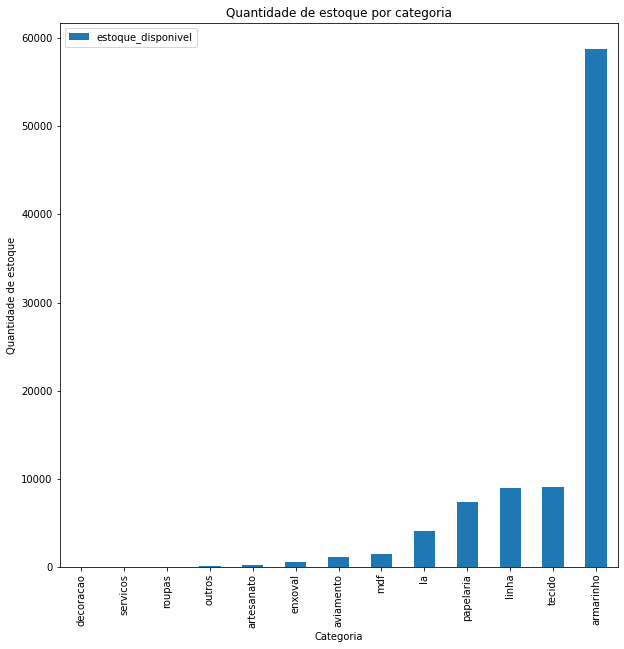

In [39]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)


from statistics import median


plot_rank_categoria_quantidade = dataframe_inventario_tratado['estoque_disponivel'].groupby(dataframe_inventario_tratado['categoria']).sum().sort_values().plot(kind='bar', title='Quantidade de estoque por categoria',
                                                                                                                figsize=(10,10))
plot_rank_categoria_quantidade.set_xlabel('Categoria') 
plot_rank_categoria_quantidade.set_ylabel('Quantidade de estoque')
plot_rank_categoria_quantidade.legend(loc='upper left')
plt.show()


Explorando as categorias que mais possuem estoque, sendo também as maiores em quantidade de produtos distintos, faremos um rank dos 10 primeiros produtos com maior quantidade de estoque presente.

In [40]:
plot_rank_categoria_quantidade_data = dataframe_inventario_tratado['estoque_disponivel'].groupby(dataframe_inventario_tratado['categoria']).sum().sort_values(ascending=False)
print("Primeira Alteração:{0} ".format(dataframe_inventario_tratado['alterado_em'].min()))
print("Última Alteração:{0} ".format(dataframe_inventario_tratado['alterado_em'].max()))
print(plot_rank_categoria_quantidade_data)


Primeira Alteração:2020-02-05 14:32:03.621000 
Última Alteração:2022-07-30 08:33:39.684000 
categoria
armarinho     58764.445
tecido         9050.890
linha          8899.000
papelaria      7395.190
la             4089.000
mdf            1426.000
aviamento      1124.650
enxoval         519.000
artesanato      234.000
outros          107.500
roupas            2.000
decoracao         0.000
servicos          0.000
Name: estoque_disponivel, dtype: float64


Com essa data de alteração do registro, é possível saber através do último registro presente que nos indica a data de extração do dado, podemos encontrar um fator
no qual representa a diferença entre a data de extração e a data de alteração do registro.
Consideraremos as datas de consideração de data de extração e data de inicio como primeiro registro de log de atividade.


In [41]:
data_extracao = dataframe_transacoes_produto_tratado['data'].max()
data_inicio = dataframe_transacoes_produto_tratado['data'].min()
diff = data_extracao - data_inicio
print("Data do estoque Inicial citado:{0} ".format(data_inicio))
print("Data do estoque presente citado:{0} ".format(data_extracao))
print("Delta:{0}".format(diff))

Data do estoque Inicial citado:2020-02-03 12:53:28.620000 
Data do estoque presente citado:2022-07-30 11:45:35.193000 
Delta:907 days 22:52:06.573000


Consideraremos dados que não possuam dada de inclusão como a data mínima de ínicio presente nos dados de transação utilizando a premissa de que seria um produto presente em estoque antes da implementação do ERP da loja.


Calcularemos uma taxa seguindo a seguinte variação:

* te_inicio_atualizacao = Delta temporal da data de inclusão até a data de extração presente do relatório
* te_atualizacao_presente = Delta temporal da data de alteração até a data de extração presente do relatório
* te_atualizacao_presente = Delta temporal da última atualização do código de inventário até a data de sua criação no sistema

Com isso, temos que:

* te_atualizacao_presente = te_inicio_presente
    fator_atualização = 0, sendo outlier como um novo produto em estoque
* te_atualizacao_presente > te_inicio_presente
    fator_atualização = (te_atualizacao_presente/te_inicio_presente)/100, nos dando um fator de última atualização
* te_inicio_presente <= 120
    fator_atualização = 0, sendo um produto recém incluso no estoque no último semestre

Nota: o "fator_atualizacao", portanto, no dará os itens mais parados em estoque tomando em conta este fator. Quanto mais próximo de 1, menos movimentado é o estoque. Isso não leva em conta seus preços. Esta heurística serve para nos guiar em termos de estoque sem analisar transações e suas tendências apenas para dar uma visão geral de itens que mais são movimentados (para mais ou para menos).

In [42]:

tempo_em_estoque = dataframe_inventario_tratado[['codigo','descricao','categoria','estoque_disponivel','preco','incluido_em','alterado_em']]
tempo_em_estoque['alterado_em'] = pd.to_datetime(tempo_em_estoque['alterado_em'])
 ## Caso não tenha data de inclusão, usa a premissa já existia no estoque
 ## Caso contrário, faz com as datas de inclusão e alteração

tempo_em_estoque_np = tempo_em_estoque['alterado_em'].to_numpy()
true_false_value_index = []
true_false_value_nat = []

for i in tempo_em_estoque_np:
    if isnat(i) == True:
        true_false_value_index.append(tempo_em_estoque['alterado_em'].index)
    true_false_value_nat.append(isnat(i))

        

for i in range(len(true_false_value_nat)):
    if true_false_value_nat[i] == True:
        aux = tempo_em_estoque['incluido_em'][true_false_value_index[0][i]]
        tempo_em_estoque['alterado_em'][true_false_value_index[0][i]] = aux
        
tempo_em_estoque.head(20) 

c:\users\otavi\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\otavi\AppData\Local\Temp/ipykernel_2404/836773007.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempo_em_estoque['alterado_em'][true_false_value_index[0][i]] = aux


,codigo,descricao,categoria,estoque_disponivel,preco,incluido_em,alterado_em
0,7100692,APLIQUE - APM4 -053 NOIVOS,papelaria,9.0,2.5,2020-11-16 17:19:42.000,2021-04-13 15:15:27.708
1,099810,BARROCO MULT 200G -9384 GREENNERY,linha,0.0,22.8,2020-03-09 10:00:50.269,2022-05-07 07:56:56.014
2,124205,ABAJUR MARINHEIRO,mdf,1.0,38.0,2020-08-07 15:58:36.302,2020-08-07 15:58:36.302
3,8099512,ABAJUR MDF DECORADO BEBE URSA,outros,1.0,65.0,2022-02-08 09:40:31.280,2022-02-08 09:41:08.406
4,7101086,ABRIDOR DE CASA G,armarinho,2.0,5.0,2021-01-26 15:42:06.736,2021-10-11 09:35:33.641
5,7100352,ABRIDOR DE CASA P,armarinho,7.0,2.5,2020-10-27 12:58:15.762,2021-10-11 09:35:54.698
6,7100369,ACRIPUFF - AMARELO OURO,papelaria,6.0,2.5,2020-10-27 15:05:06.788,2021-06-25 09:59:20.733
8,7100372,ACRIPUFF - BRANCO,papelaria,2.0,2.5,2020-10-27 15:42:30.541,2021-06-25 09:59:33.484
10,7100370,ACRIPUFF - PRETO,papelaria,4.0,2.5,2020-10-27 15:40:31.781,2021-06-25 09:59:57.732
12,7100371,ACRIPUFF - VERMELHO,papelaria,2.0,2.5,2020-10-27 15:41:18.222,2021-06-25 10:00:10.741


In [43]:
tempo_em_estoque = pd.merge(tempo_em_estoque, dataframe_deprec, on='categoria')
tempo_em_estoque



,codigo,descricao,categoria,estoque_disponivel,preco,incluido_em,alterado_em,ncm,taxa_depreciacao
0,7100692,APLIQUE - APM4 -053 NOIVOS,papelaria,9.0,2.5,2020-11-16 17:19:42.000,2021-04-13 15:15:27.708,3926,0
1,7100369,ACRIPUFF - AMARELO OURO,papelaria,6.0,2.5,2020-10-27 15:05:06.788,2021-06-25 09:59:20.733,3926,0
2,7100372,ACRIPUFF - BRANCO,papelaria,2.0,2.5,2020-10-27 15:42:30.541,2021-06-25 09:59:33.484,3926,0
3,7100370,ACRIPUFF - PRETO,papelaria,4.0,2.5,2020-10-27 15:40:31.781,2021-06-25 09:59:57.732,3926,0
4,7100371,ACRIPUFF - VERMELHO,papelaria,2.0,2.5,2020-10-27 15:41:18.222,2021-06-25 10:00:10.741,3926,0
...,...,...,...,...,...,...,...,...,...
5242,099711,LÃ VINY - 810,la,1.0,19.8,2020-03-06 10:57:20.217,2021-06-18 10:25:14.662,6303,20
5243,7101808,LINHA CHARME - 8001 BRANCA,la,6.0,21.5,2021-11-19 11:09:01.235,2022-05-18 17:32:47.208,6303,20
5244,8099708,LINHA CLÉA 1000 -2314,la,6.0,21.5,2022-04-04 12:17:55.857,2022-05-05 13:15:43.387,6303,20
5245,8099767,Tapete barbante Urso,decoracao,0.0,60.0,2022-05-07 11:57:18.353,2022-05-07 11:57:18.353,6303,20


Aqui criaremos uma maneira de relacionar o tempo de alteração de estoque com a data de número índice de IPCA, para cruzar os dados de valor inicial. Consideraremos para Valor final, o último índice

In [44]:

tempo_em_estoque['ano_mes'] = tempo_em_estoque['alterado_em'].apply(lambda x: x.strftime('%Y-%m')) ## Gerando a chave de ano e mês
dataframe_ipca['ano_mes'] = dataframe_ipca['mes'].apply(lambda x: x.strftime('%Y-%m')) ## Gerando a chave de ano e mês



In [45]:
dataframe_ipca.head()



,mes,indice,ano_mes
0,2020-03-01,5348.49,2020-03
1,2020-04-01,5331.91,2020-04
2,2020-05-01,5311.65,2020-05
3,2020-06-01,5325.46,2020-06
4,2020-07-01,5344.63,2020-07


In [46]:
#trazer o valor de dataframe_ipca['indice'] para o último mes de dataframe_ipca['mes']


In [47]:
tempo_em_estoque = pd.merge(tempo_em_estoque, dataframe_ipca, on='ano_mes')

In [48]:
indice_atual_aplicado =  dataframe_ipca['indice'].loc[dataframe_ipca['mes'] == dataframe_ipca['mes'].max()]

In [49]:
for index, row in tempo_em_estoque.iterrows():
        
        tempo_em_estoque.loc[index,'te_inicio_presente'] = (data_extracao - row['incluido_em']).days #Tempo total de estoque em dias do ínicio de inclusão até última atualização
        tempo_em_estoque.loc[index,'te_atualizacao_presente'] = (data_extracao - row['alterado_em']).days #Tempo total de estoque em dias do ínicio de inclusão até última atualização
        tempo_em_estoque.loc[index,'te_inicio_atualizacao'] = (row['alterado_em'] - row['incluido_em']).days #Tempo total de estoque em dias do ínicio de inclusão até última atualização
        tempo_em_estoque.loc[index,'anos_estoque'] = (row['alterado_em'] - row['incluido_em']).days/365.2425 #Tempo total de estoque em anos do ínicio de inclusão até última atualização
        
        if tempo_em_estoque.loc[index,'estoque_disponivel'] == 0:
                  tempo_em_estoque.loc[index,'clf_estoque'] = 'Produto não está em estoque'
                  tempo_em_estoque.loc[index,'fator_atualizacao'] = 1
        elif tempo_em_estoque.loc[index,'te_inicio_presente'] <= 90:
              tempo_em_estoque.loc[index,'clf_estoque'] = 'Produto alterado no último trimestre'
              try:
                      tempo_em_estoque.loc[index,'fator_atualizacao'] = 1 - (tempo_em_estoque.loc[index,'te_atualizacao_presente'] / tempo_em_estoque.loc[index,'te_inicio_presente'])
              except ZeroDivisionError:
                        tempo_em_estoque.loc[index,'fator_atualizacao'] == 0 

        elif tempo_em_estoque.loc[index,'te_inicio_presente'] > tempo_em_estoque.loc[index,'te_atualizacao_presente']:
                tempo_em_estoque.loc[index,'clf_estoque'] = 'Produto no estoque'
                tempo_em_estoque.loc[index,'fator_atualizacao'] = (tempo_em_estoque.loc[index,'te_atualizacao_presente']/tempo_em_estoque.loc[index,'te_inicio_presente'])
        else:
                tempo_em_estoque.loc[index,'clf_estoque'] = 'Risco de estoque parado'
                tempo_em_estoque.loc[index,'fator_atualizacao'] = 1  



for index, row in tempo_em_estoque.iterrows():
        if row['anos_estoque'] < 1:
            tempo_em_estoque.loc[index,'depreciacao'] = 0
        else:
            tempo_em_estoque.loc[index,'depreciacao'] = row['preco']*((row['taxa_depreciacao']/100)**row['anos_estoque'])
        tempo_em_estoque.loc[index,'valor_estoque_depreciado'] = row['estoque_disponivel']*row['preco']*((row['taxa_depreciacao']/100)**row['anos_estoque'])



In [50]:
tempo_em_estoque.head(50).sort_values(by=['fator_atualizacao'], ascending=False)


,codigo,descricao,categoria,estoque_disponivel,preco,incluido_em,alterado_em,ncm,taxa_depreciacao,ano_mes,mes,indice,te_inicio_presente,te_atualizacao_presente,te_inicio_atualizacao,anos_estoque,clf_estoque,fator_atualizacao,depreciacao,valor_estoque_depreciado
49,7100809,APLIQUE - APM12-073 MENINA,papelaria,2.0,5.00,2020-11-26 13:38:36.150,2020-11-26 13:38:36.150,3926,0,2020-11,2020-11-01,5486.52,610.0,610.0,0.0,0.000000,Risco de estoque parado,1.000000,0.000000,10.000000
41,7101466,ENTRETELA COLANTE,armarinho,4082.0,0.06,2021-06-23 13:38:13.058,2021-06-23 13:45:29.913,8452,10,2021-06,2021-06-01,5769.98,401.0,401.0,0.0,0.000000,Risco de estoque parado,1.000000,0.000000,244.920000
1,099939,MASSA BISCUIT acrilex 90G - AMARELO PELE,papelaria,0.0,4.50,2020-03-12 09:25:38.569,2021-04-13 14:54:44.957,3926,0,2021-04,2021-04-01,5692.31,870.0,472.0,397.0,1.086949,Produto não está em estoque,1.000000,0.000000,0.000000
24,099772,LÃ TODO DIA - 70028 CINZA,la,0.0,15.80,2020-03-06 15:15:42.995,2021-04-23 12:35:56.233,6303,20,2021-04,2021-04-01,5692.31,875.0,462.0,412.0,1.128018,Produto não está em estoque,1.000000,2.571619,0.000000
31,099936,MASSA BISCUIT acrilex 90G - MARROM,papelaria,0.0,4.50,2020-03-12 09:14:12.933,2021-06-29 09:13:46.135,3926,0,2021-06,2021-06-01,5769.98,870.0,396.0,473.0,1.295030,Produto não está em estoque,1.000000,0.000000,0.000000
32,7101420,NOTA PROMISSORIA,papelaria,6.0,3.50,2021-06-16 09:10:48.283,2021-06-16 09:10:48.283,3926,0,2021-06,2021-06-01,5769.98,409.0,409.0,0.0,0.000000,Risco de estoque parado,1.000000,0.000000,21.000000
33,099409,BARBANTE LIMA 6 AMARELO OURO,linha,0.0,21.00,2020-03-02 14:10:27.539,2021-06-25 15:45:14.122,6303,20,2021-06,2021-06-01,5769.98,879.0,399.0,480.0,1.314195,Produto não está em estoque,1.000000,2.533006,0.000000
34,099425,BARBANTE LIMA 8 MOSTARDA,linha,0.0,21.00,2020-03-03 10:08:30.360,2021-06-29 09:04:07.379,6303,20,2021-06,2021-06-01,5769.98,879.0,396.0,482.0,1.319671,Produto não está em estoque,1.000000,2.510780,0.000000
35,7099905,MEADA ANCHOR METALIZADA- 300 DOURADA,linha,0.0,6.90,2020-09-19 11:34:43.939,2021-06-29 09:15:33.174,6303,20,2021-06,2021-06-01,5769.98,679.0,396.0,282.0,0.772090,Produto não está em estoque,1.000000,0.000000,0.000000
36,098995,NICHO QUADRADO 30X30X18,mdf,0.0,21.00,2020-02-17 11:02:37.469,2021-06-29 09:15:57.693,4415,20,2021-06,2021-06-01,5769.98,894.0,396.0,497.0,1.360740,Produto não está em estoque,1.000000,2.350190,0.000000


In [51]:
classificacao_inv = tempo_em_estoque.groupby('clf_estoque').agg({'categoria': 'nunique', 'codigo': 'count'})
classificacao_inv.head()

,categoria,codigo
clf_estoque,,
Produto alterado no último trimestre,10,186
Produto no estoque,9,3130
Produto não está em estoque,12,927
Risco de estoque parado,10,878


<Figure size 640x480 with 0 Axes>

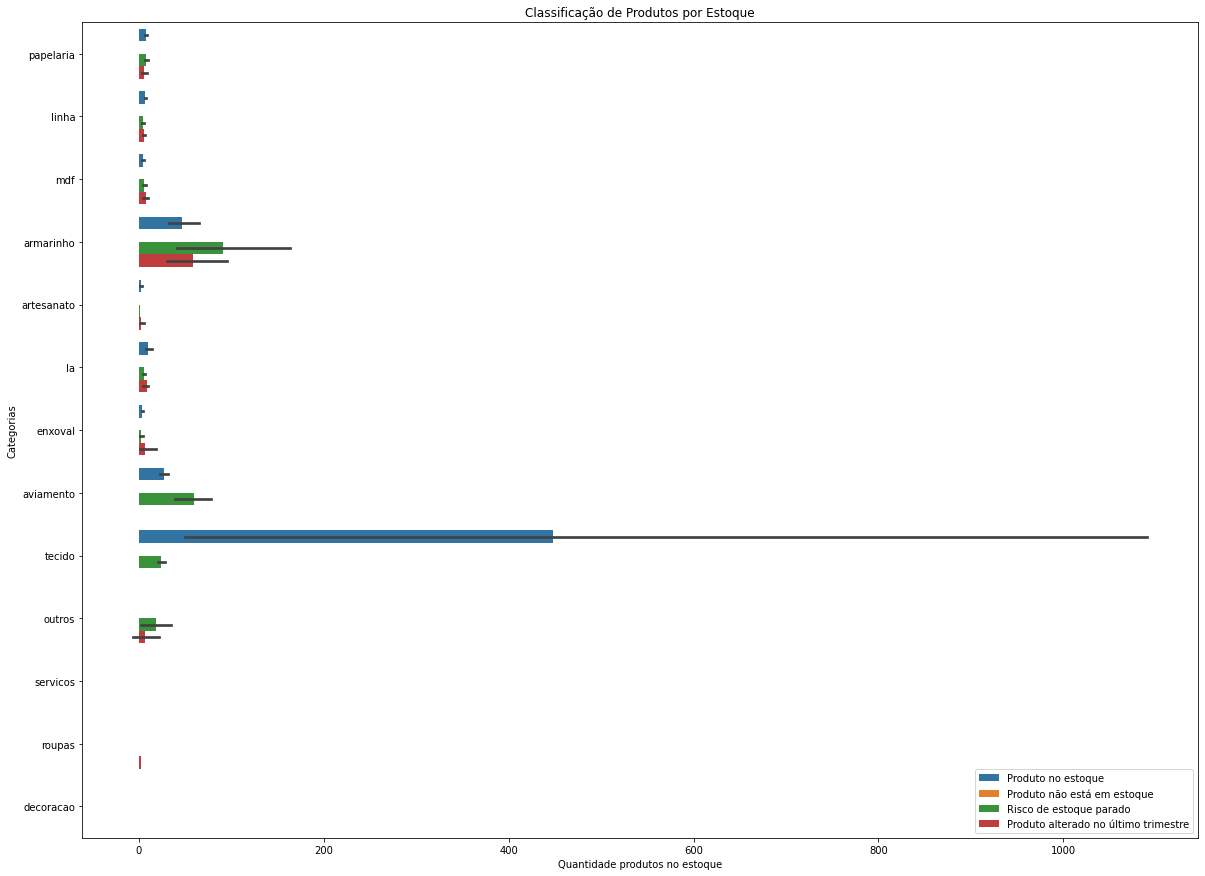

<Figure size 1440x1440 with 0 Axes>

In [52]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

#plot by clf_estoque from tempo_em_estoque

plot_classificacao_inv = sns.barplot(x='estoque_disponivel', y='categoria', data=tempo_em_estoque, hue='clf_estoque')
plot_classificacao_inv.set_xlabel('Quantidade produtos no estoque')
plot_classificacao_inv.set_ylabel('Categorias')
plot_classificacao_inv.set_title('Classificação de Produtos por Estoque')
plot_classificacao_inv.legend(loc='lower right')
plt.figure(figsize=(20,20))
plt.show()

In [53]:
tempo_em_estoque_parado = tempo_em_estoque[tempo_em_estoque['clf_estoque'] == 'Risco de estoque parado']
agrupamento_clf = tempo_em_estoque_parado.groupby(['categoria']).agg({'codigo': 'count','preco': 'mean','estoque_disponivel': 'mean','valor_estoque_presente': 'mean'})
agrupamento_clf

KeyError: "Column(s) ['valor_estoque_presente'] do not exist"

Será considerado uma análise dos itens classificados como "Risco de estoque parado".

In [ ]:
agrupamento_risco = tempo_em_estoque[tempo_em_estoque['clf_estoque'] == 'Risco de estoque parado'].groupby(['clf_estoque','categoria']).agg({'codigo': 'count','preco': 'mean','estoque_disponivel': 'mean','te_inicio_presente': 'mean','te_atualizacao_presente': 'mean','te_inicio_atualizacao': 'mean','fator_atualizacao': 'mean','valor_estoque_presente': 'mean','depreciacao': 'mean','valor_estoque_depreciado': ''})
for index, row in agrupamento_risco.iterrows():
    agrupamento_risco = agrupamento_risco.drop(index)

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,50)
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

b=sns.violinplot(x = 'categoria',y='valor_estoque_presente', data=tempo_em_estoque, hue='clf_estoque')
b.set_xlabel('Categoria')
b.set_ylabel('Valor do estoque')
b.set_title('Valor do estoque por categoria')
plt.figure(figsize=(20,20))
plot_classificacao_inv.legend(loc='upper left')
plt.show()


In [ ]:
#Rank de produtos em estoque por categoria que quase nunca foram atualizados
#top_10_fator_atualizacao_1 = tempo_em_estoque[tempo_em_estoque['te_inicio_atualizacao'] < 1 and tempo_em_estoque['fator_atualizacao'] >= 0.7]   
#top_10_fator_atualizacao_1 = top_10_fator_atualizacao_1.sort_values(by=['fator_atualizacao'], ascending=False).groupby('clf_estoque')
#
#top_10_fator_atualizacao_1[['categoria','descricao','estoque_disponivel','te_inicio_atualizacao','fator_atualizacao']].head(50)


In [ ]:
#Rank de produtos em estoque por categoria com risco de estarem parados
top_10_fator_atualizacao_2 = tempo_em_estoque[tempo_em_estoque['fator_atualizacao'] == 1]
top_10_fator_atualizacao_2 = top_10_fator_atualizacao_2.sort_values(by=['fator_atualizacao'], ascending=False).groupby('clf_estoque')

top_10_fator_atualizacao_2[['categoria','descricao','estoque_disponivel','te_inicio_atualizacao','fator_atualizacao']].head(50)



In [ ]:
#Rank de produtos em estoque por categoria com risco de estarem parados
top_10_fator_atualizacao = tempo_em_estoque[tempo_em_estoque['fator_atualizacao'].astype(float) <= 0.49 & tempo_em_estoque['fator_atualizacao'].astype(float) >= 0.1]
top_10_fator_atualizacao = top_10_fator_atualizacao.sort_values(by=['fator_atualizacao'], ascending=False).groupby('clf_estoque')

top_10_fator_atualizacao[['categoria','descricao','estoque_disponivel','te_inicio_atualizacao','fator_atualizacao']].head(50)



In [ ]:
g = sns.PairGrid(tempo_em_estoque, hue="categoria")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [ ]:
g = sns.PairGrid(tempo_em_estoque, hue="clf_estoque")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [54]:
g = sns.PairGrid(tempo_em_estoque['clf_estoque'] == 'Risco de estoque parado', hue='categoria')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

KeyError: False

DataFrme de Produtos

In [55]:
~
ç.dataframe_transacoes_produto_tratado

SyntaxError: invalid syntax (Temp/ipykernel_2404/3133316706.py, line 1)

In [56]:
dataframe_transacoes_produto_tratado['Tipo'].value_counts()

KeyError: 'Tipo'

In [57]:
#bring unique values of codigo and categoria from tempo_em_estoque
tempo_em_estoque_uniq = tempo_em_estoque[['codigo','categoria','descricao']].drop_duplicates(keep='first')

#check duplicates 
tempo_em_estoque_uniq.duplicated().sum()

tempo_em_estoque_uniq.rename(columns={'descricao': 'produto'}, inplace=True)
tempo_em_estoque_uniq


,codigo,categoria,produto
0,7100692,papelaria,APLIQUE - APM4 -053 NOIVOS
1,099939,papelaria,MASSA BISCUIT acrilex 90G - AMARELO PELE
2,099935,papelaria,MASSA BISCUIT acrilex 90G - VERDE MUSGO
3,099993,papelaria,PINCEL TIGRE 815 - 04
4,099996,papelaria,PINCEL TIGRE 815 - 10
...,...,...,...
5116,7100714,enxoval,PANO DE COPA NATAL PAPAI NOEL
5117,099804,tecido,TNT AZUL
5118,123594,la,LÃ BADEN - 20 VERMELHO
5119,099599,la,LÃ COLORPULL 8663


In [58]:


dataframe_transacoes_produto_tratado_1 = dataframe_transacoes_produto_tratado[dataframe_transacoes_produto_tratado['tipo'] == 'Venda']
dataframe_transacoes_produto_tratado_1= dataframe_transacoes_produto_tratado_1.drop_duplicates(keep='first')
dataframe_transacoes_produto_tratado_1.duplicated().sum()

0

In [59]:
dataframe_transacoes_produto_tratado_2 = dataframe_transacoes_produto_tratado_1.merge(tempo_em_estoque_uniq, on='produto', how='left')


In [60]:
dataframe_transacoes_produto_tratado_2

,tipo,numero,data,hora,produto,quant_,vl__unitario,sub_total,desconto,outras_despesas,total,codigo,categoria
0,Venda,38253.0,2022-07-30 11:45:35.193,2022-07-30 11:45:35.193,TECIDO TRICOLINE DIVERSOS,-0.25,27.90,6.97,0.0,0,6.97,123889,tecido
1,Venda,38252.0,2022-07-30 09:45:20.596,2022-07-30 09:45:20.596,FITA CETIM PROGRESSO 0 -209 VERMELHO,-100.00,0.35,35.00,7.0,0,28.00,7099759,armarinho
2,Venda,38251.0,2022-07-30 09:36:37.140,2022-07-30 09:36:37.140,"FITA MÉTRICA NYBC 1,5m",-1.00,5.80,5.80,0.0,0,5.80,099927,armarinho
3,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,COSTURA DRIMA - Branca,-1.00,3.00,3.00,0.0,0,3.00,N126100-0000B,linha
4,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,COSTURA DRIMA - 5605,-1.00,3.00,3.00,0.0,0,3.00,123557,linha
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18412,Venda,11639.0,2020-09-13 16:47:04.101,2020-09-13 16:47:04.101,Linha Rayza - Vermelho,-1.00,8.50,8.50,0.0,0,8.50,98008,linha
18413,Venda,11639.0,2020-09-13 16:47:04.101,2020-09-13 16:47:04.101,Linha Rayza - Preto,-2.00,8.50,17.00,0.0,0,17.00,98010,linha
18414,Venda,11639.0,2020-09-13 16:47:04.101,2020-09-13 16:47:04.101,Linha Rayza - Azul Turquesa,-1.00,8.50,8.50,0.0,0,8.50,98022,linha
18415,Venda,11638.0,2020-09-13 16:46:32.133,2020-09-13 16:46:32.133,Linha Rayza - Lilás,-2.00,8.50,17.00,0.0,0,17.00,98006,linha


In [61]:
df = dataframe_transacoes_produto_tratado_2[['categoria','total','data']]
df

,categoria,total,data
0,tecido,6.97,2022-07-30 11:45:35.193
1,armarinho,28.00,2022-07-30 09:45:20.596
2,armarinho,5.80,2022-07-30 09:36:37.140
3,linha,3.00,2022-07-29 17:29:13.607
4,linha,3.00,2022-07-29 17:29:13.607
...,...,...,...
18412,linha,8.50,2020-09-13 16:47:04.101
18413,linha,17.00,2020-09-13 16:47:04.101
18414,linha,8.50,2020-09-13 16:47:04.101
18415,linha,17.00,2020-09-13 16:46:32.133


<Figure size 640x480 with 0 Axes>

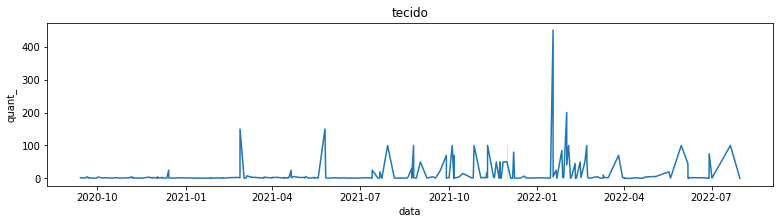

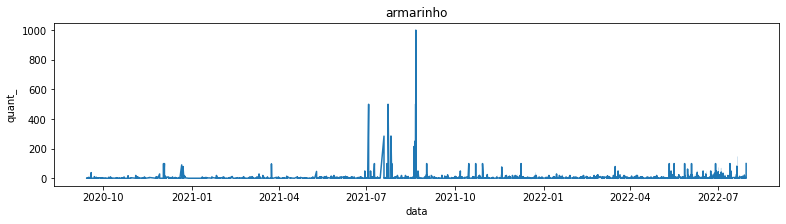

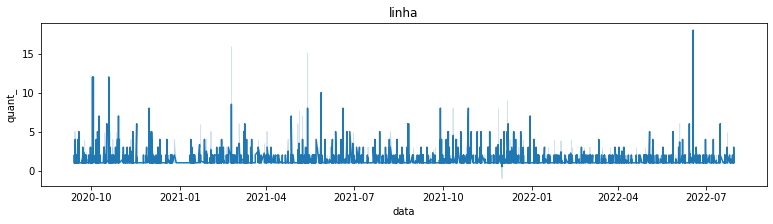

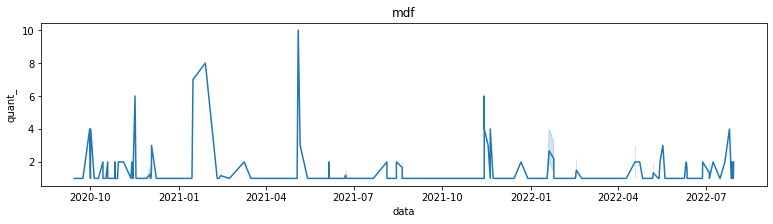

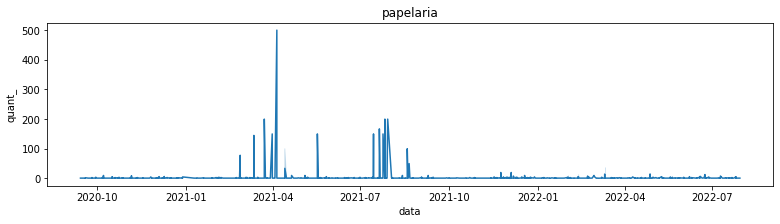

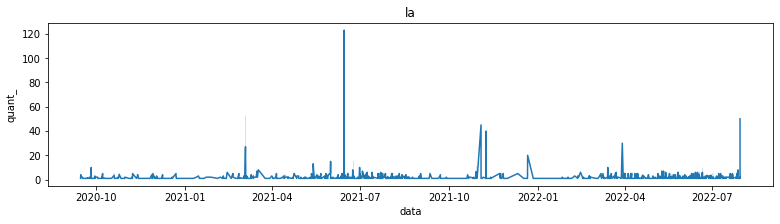

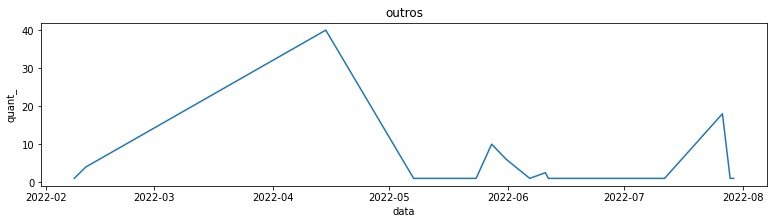

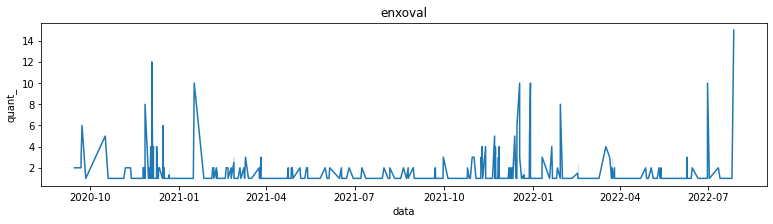

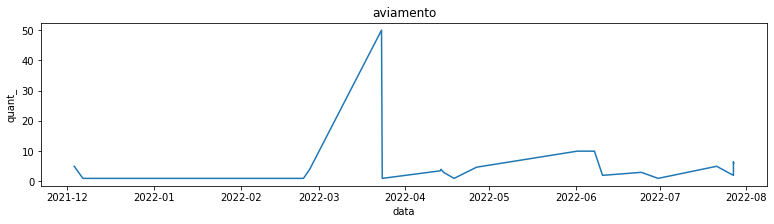

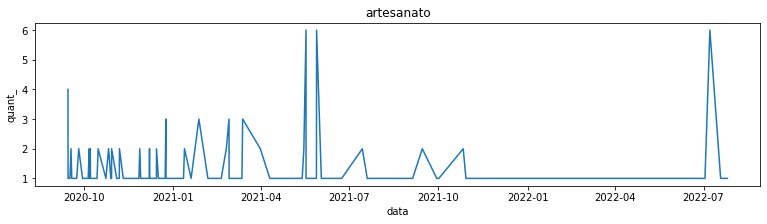

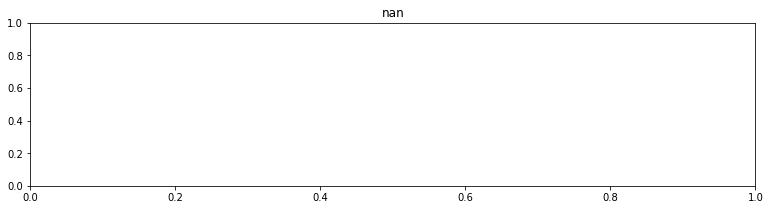

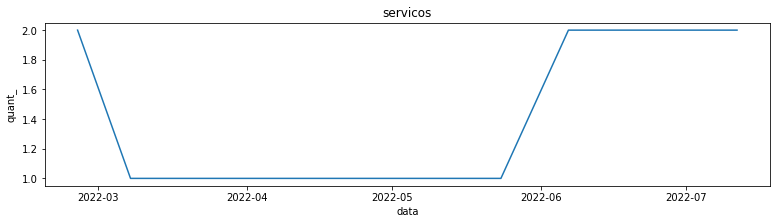

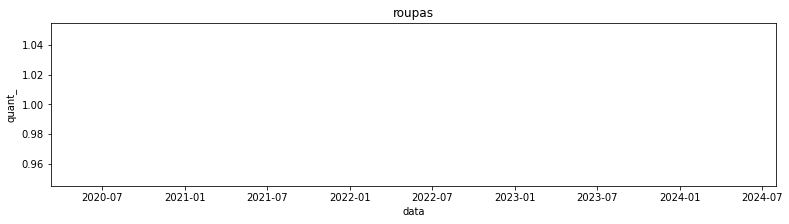

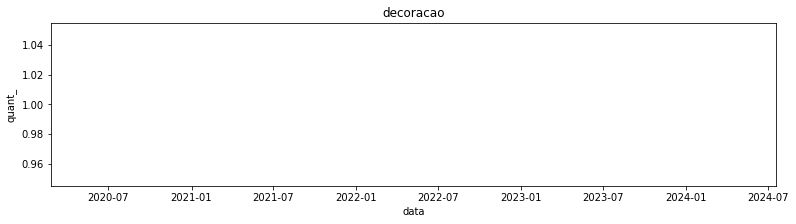

In [145]:
#sns timeplot hue categoria dataframe_transacoes_produto_tratado_2 by venda and data
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,3)
fig, ax = plt.subplots()
#create a time plot 
for categoria in dataframe_transacoes_produto_tratado_2['categoria'].unique():
    dataframe_transacoes_produto_tratado_2_categoria = dataframe_transacoes_produto_tratado_2[dataframe_transacoes_produto_tratado_2['categoria'] == categoria]
    sns.lineplot(x='data', y=(dataframe_transacoes_produto_tratado_2_categoria['quant_']*-1), data=dataframe_transacoes_produto_tratado_2_categoria)
    plt.title(categoria)
    plt.show()




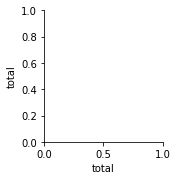

In [63]:
sns.PairGrid(df[['categoria','data','total']], hue ='categoria')
plt.show()

c:\users\otavi\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\otavi\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
c:\users\otavi\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\otavi\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
c:\users\otavi\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\otavi\

LinAlgError: singular matrix

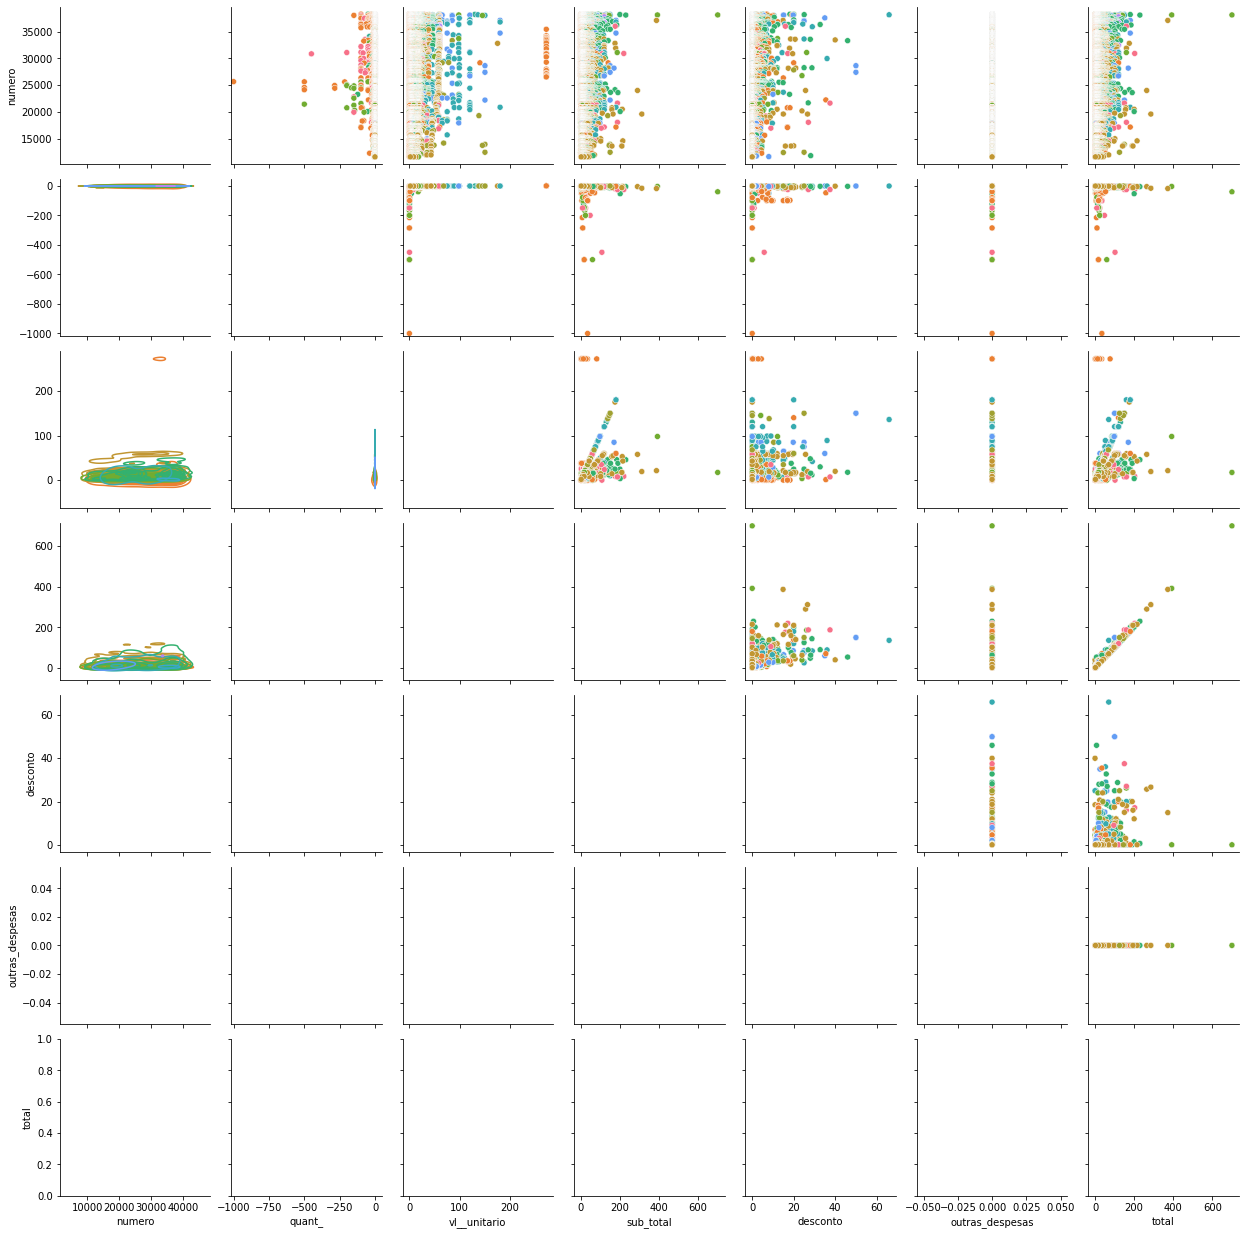

In [64]:
g = sns.PairGrid(dataframe_transacoes_produto_tratado_2,hue='categoria')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

ZeroDivisionError: division by zero

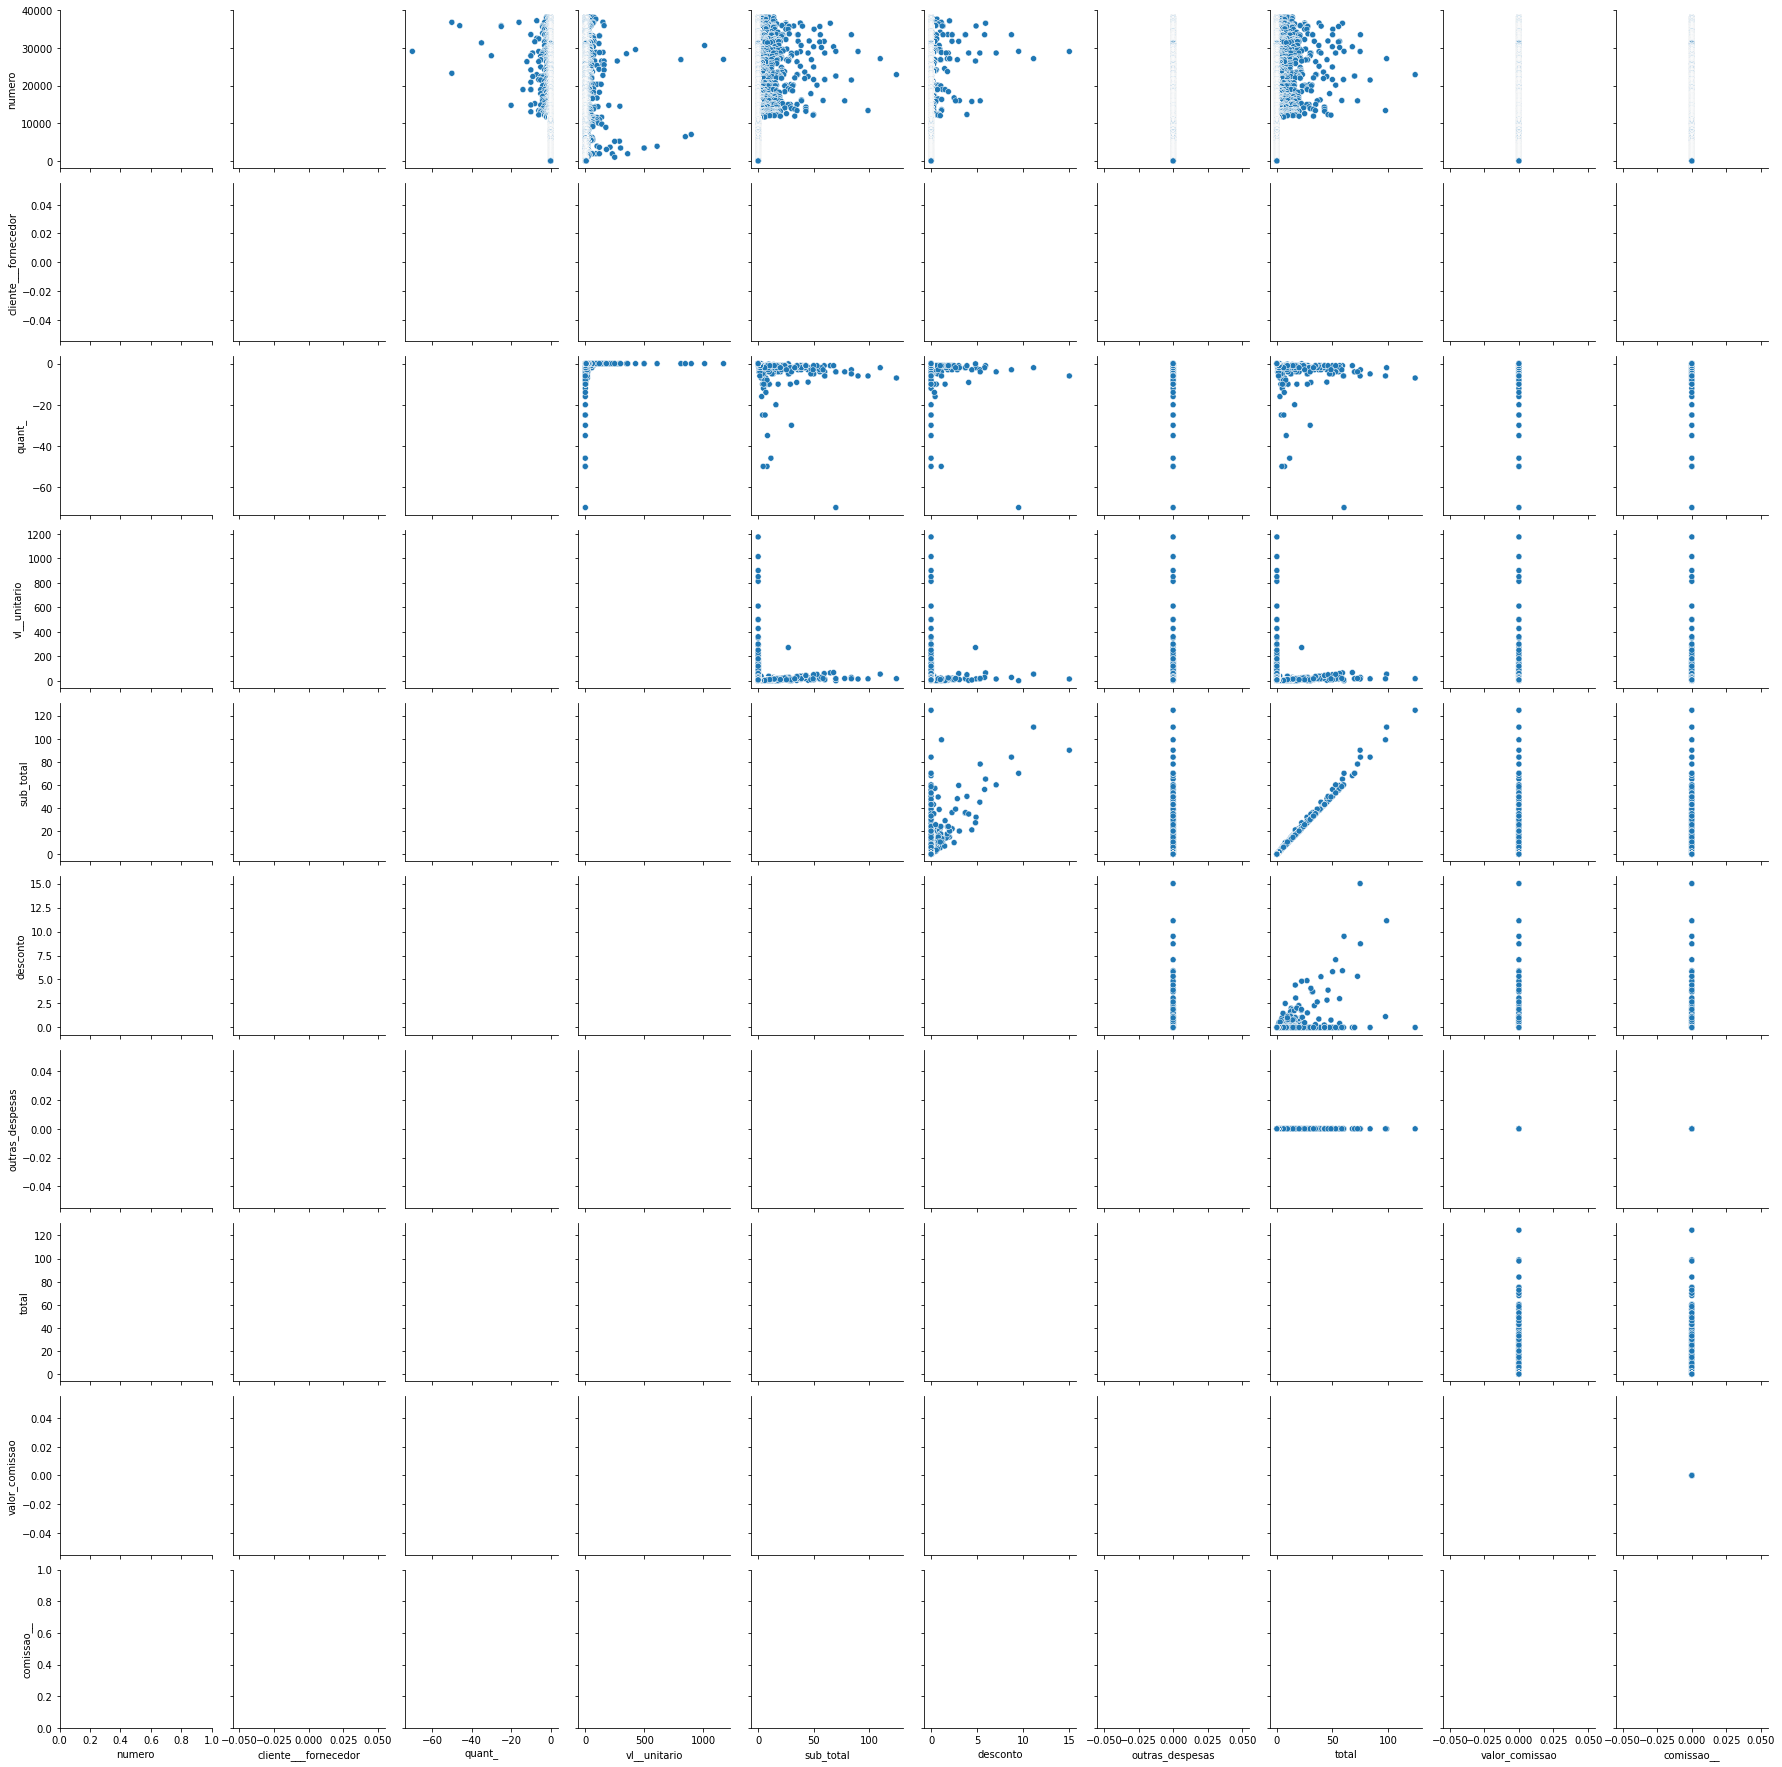

In [ ]:
g = sns.PairGrid(dataframe_transacoes_produto_tratado[dataframe_transacoes_produto_tratado['tipo'] == 'Ajuste de Custo'],hue='tipo')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

In [ ]:
g = sns.PairGrid(dataframe_transacoes_produto_tratado[dataframe_transacoes_produto_tratado['tipo'] == 'Ajuste de Estoque +'],hue='tipo')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

In [ ]:
g = sns.PairGrid(dataframe_transacoes_produto_tratado[dataframe_transacoes_produto_tratado['tipo'] == 'Ajuste de Estoque -'],hue='tipo')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)